In [1]:
from sklearn.cross_decomposition import CCA
import numpy as np
import pickle
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
from scipy.stats import zscore

import sys
sys.path.insert(0, '../SAC/')
import kinematics_preprocessing_specs

import config

parser = config.config_parser()
args, unknown = parser.parse_known_args()

In [3]:
#Load the test data of nusim

with open('../test_data/test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)
    
print(test_data.keys())

dict_keys(['emg', 'rnn_activity', 'rnn_input', 'rnn_input_fp', 'kinematics_mbodies', 'kinematics_mtargets'])


In [5]:
#Get the timepoints of each condition per cycle
with open('../kinematics_data/kinematics.pkl', 'rb') as file:
    kin_train_test = pickle.load(file)
    
kin_train = kin_train_test['train']
kin_test = kin_train_test['test']

#First update the keys of self.kin_test
for cond in range(len(kin_test)):
    kin_test[len(kin_train) + cond] = kin_test.pop(cond)
    
kin = kin_train
kin.update(kin_test)

In [7]:
#Get the experimental neural data

with open('../nusim_neural_data/neural_activity_train.pkl', 'rb') as file:
    neural_train = pickle.load(file)

with open('../nusim_neural_data/neural_activity_test.pkl', 'rb') as file:
    neural_test = pickle.load(file)

#First update the keys of self.kin_test
for cond in range(len(neural_test)):
    neural_test[len(neural_train) + cond] = neural_test.pop(cond)
    
neural = neural_train
neural.update(neural_test)

In [27]:
conds = [kin[cond].shape[-1] for cond in range(len(kin))]
total_conds = len(conds)

#Select the cycle for each condition (training conditions followed by testing): 0 for 1st cycle and so on
#The number of elements should be equal to num_train_conditions + num_test_conditions
cycles = [2, 2, 2, 2, 2, 2]

#Number of fixedsteps in the start of each condition
n_fixedsteps= args.n_fixedsteps

In [29]:
#index of conds to include in the CCA analysis
conds_analysis= [0, 1, 2, 3, 4, 5]

In [31]:
test_data.keys()
test_data['rnn_activity'][0].shape

(6000, 256)

In [33]:
#Load the network activities
A_agent = []

for idx, cond_activity in test_data['rnn_activity'].items():
    act_agent = cond_activity
    act_agent = act_agent[n_fixedsteps + cycles[idx] * conds[idx] : n_fixedsteps + (cycles[idx]+1) * conds[idx]]
    print(act_agent.shape)
    A_agent.append(act_agent[:, :])

(702, 256)
(803, 256)
(932, 256)
(1319, 256)
(619, 256)
(1106, 256)


In [35]:
# Load the experimental neural activities
A_exp = []
for cond in range(len(neural)):
    act_exp = neural[cond]
    print(act_exp.shape)
    A_exp.append(act_exp)

(702, 49)
(803, 49)
(932, 49)
(1319, 49)
(619, 49)
(1106, 49)


/home/noman/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


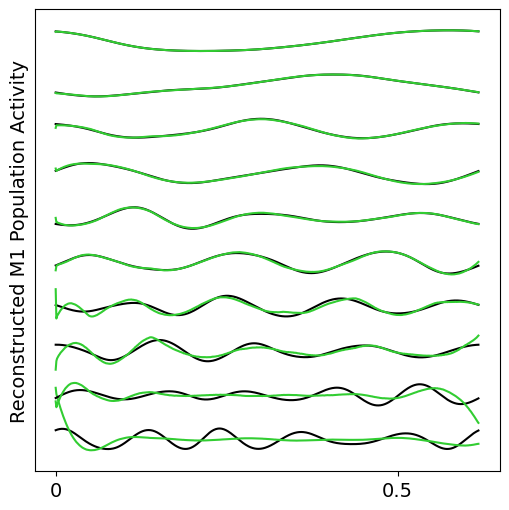

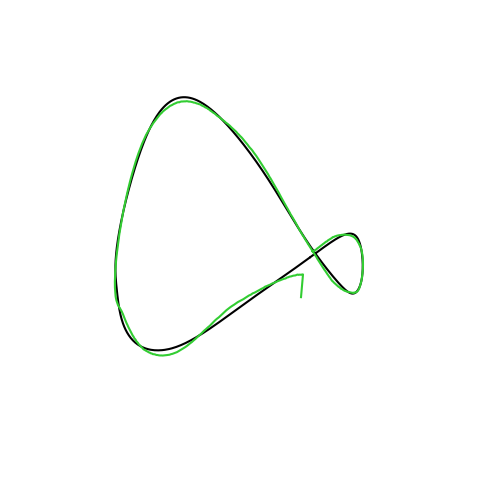

Now printing the correlations
CC1 R2 0.999988574691451
CC2 R2 0.9996547617156106
CC3 R2 0.9958707425227467
CC4 R2 0.995144569760956
CC5 R2 0.9895661083783281
CC6 R2 0.9896324103565417
CC7 R2 0.7771718310683187
CC8 R2 0.6853744366246824
CC9 R2 -0.046418784280164216
CC10 R2 -0.21130867166761647
Average R2 [Agent Canonical Activity transformed in Exp PC Space] 0.7174675979170855


In [37]:
#Select the condition to do the CCA
#Test Conditions are followed by Train conditions
cond = 4

A_exp_cca = A_exp[cond]
A_agent_cca = A_agent[cond]

#Select the number of components for PCA and CCA
n_comps = 10
PC_agent = PCA(n_components= n_comps)
PC_exp = PCA(n_components= n_comps)

A_exp_cca = PC_exp.fit_transform(A_exp_cca)
A_agent_cca = PC_agent.fit_transform(A_agent_cca)

cca = CCA(n_components =n_comps, scale= True)
exp_c, agent_c = cca.fit_transform(A_exp_cca, A_agent_cca)
# print(cca.score(A_exp_cca, A_agent_cca))

#Transform the canonical agent's activity back into the original experimental PC space
exp_prime = cca.inverse_transform(agent_c)

plt.figure(figsize= (6, 6))

for k in range(n_comps):
    if k==0:
        plt.plot(A_exp_cca[:,n_comps-1-k]/np.max(A_exp_cca[:,n_comps-1-k]) + k*4, linewidth=1.5, c = 'k')
        plt.plot(exp_prime[:,n_comps-1-k]/np.max(A_exp_cca[:,n_comps-1-k]) + k*4, linewidth= 1.5, c=(50/255, 205/255, 50/255), label= 'Network Reconstruction')
    else:
        plt.plot(A_exp_cca[:, n_comps -1 - k]/np.max(A_exp_cca[:,n_comps-1-k]) + k * 4, linewidth=1.5, c='k')
        plt.plot(exp_prime[:, n_comps -1 - k]/np.max(A_exp_cca[:,n_comps-1-k]) + k * 4, linewidth=1.5, c=(50 / 255, 205 / 255, 50 / 255))

plt.ylabel('Reconstructed M1 Population Activity', size=14)
plt.xticks([0, 500], ['0', '0.5'], size= 14)
plt.yticks([])
plt.show()

#Now plot the PCs on the same plot here
ax = plt.figure(figsize= (6,6), dpi=100).add_subplot(projection='3d')
ax.plot(A_exp_cca[:,0], A_exp_cca[:, 1], A_exp_cca[:, 2], c = 'k')
ax.plot(exp_prime[:,0], exp_prime[:, 1], exp_prime[:, 2], c=(50/255, 205/255, 50/255))

# Hide grid lines
ax.grid(False)
plt.grid(b=None)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')

plt.show()
# plt.savefig('C:/Users/malma/Dropbox/NatureFigs2/Fig2/PCA_619.svg', format='svg', dpi=300, transparent= True)


print('Now printing the correlations')

for comp in range(n_comps):
    print(f'CC{comp+1} R2', r2_score(A_exp_cca[:, comp], exp_prime[:, comp]))

sum = 0
for k in range(n_comps):
    sum = sum + r2_score(A_exp_cca[:, k], exp_prime[:, k])
average = sum / n_comps;

print('Average R2 [Agent Canonical Activity transformed in Exp PC Space]', average)

In [39]:
#Now do the CCA by transforming the experimental activity into agent's population space
#Transform the canonical experimental activity into the agent's population space
agent_prime = exp_c @ np.linalg.inv(cca.y_weights_)
agent_prime = agent_prime * np.std(A_agent_cca, axis= 0) + np.mean(A_agent_cca, axis= 0)

#Plot the R2 between the transform exp_canonical and agent population activity
sum = 0
for k in range(n_comps):
    print(f'CC{k+1} R2', r2_score(A_agent_cca[:, k], agent_prime[:, k]))
    
    sum = sum + r2_score(A_agent_cca[:, k], agent_prime[:, k])
average = sum / n_comps;

#The agent's population/pca activity as explained by the inverse CCA experimental activity
print('Average R2 [Exp Canonical Activity transformed in Agent PC Space]', average)

CC1 R2 0.9998521124477896
CC2 R2 0.9999154774286575
CC3 R2 0.7898788812307532
CC4 R2 0.9693562478476777
CC5 R2 0.8423896630940062
CC6 R2 0.912512871376749
CC7 R2 0.3390527026807524
CC8 R2 0.6984144827303018
CC9 R2 0.6778364814077065
CC10 R2 -0.05225816404797978
Average R2 [Exp Canonical Activity transformed in Agent PC Space] 0.7176950756196414


In [41]:
#Now find the explained variance ratio of the agent population/PC subspace

A_agent_z = (A_agent_cca - np.mean(A_agent_cca, axis= 0)) / np.std(A_agent_cca, axis= 0)
# A_agent_z = zscore(A_agent_cca, ddof= 1 )
A_agent_zm = A_agent_z - np.mean(A_agent_z, axis= 0)

#Find the covariance matrix of the agent population/pca activity
C_agent = (A_agent_zm.T@A_agent_zm)/(A_agent_zm.shape[0]-1)

variance_explained= 0
for comp in range(n_comps):
    explained_variance_ratio = (cca.y_weights_[:, comp]@C_agent@cca.y_weights_[:, comp].T)/np.sum(np.diag(C_agent))
    variance_explained += explained_variance_ratio
    print(f'Variance explained by CC{comp+1}' , explained_variance_ratio)

print('Variance Explained', variance_explained)

Variance explained by CC1 0.10000000770853594
Variance explained by CC2 0.10000048118494222
Variance explained by CC3 0.1000035314706818
Variance explained by CC4 0.10000203096366256
Variance explained by CC5 0.10000186888557269
Variance explained by CC6 0.10006262504438744
Variance explained by CC7 0.10000011610592106
Variance explained by CC8 0.09993114842794806
Variance explained by CC9 0.09995417128113024
Variance explained by CC10 0.10004405463222651
Variance Explained 1.0000000357050085


In [43]:
#Concatenate the musim activity for all conditions
for idx_cond, i_cond in enumerate(conds_analysis):
    
    if idx_cond == 0:
        A_agent_cum = A_agent[i_cond]
    else:
        A_agent_cum = np.concatenate((A_agent_cum, A_agent[i_cond]), axis=0)
        
#Concatenate the experimental neural activity for all conditions
for idx_cond, i_cond in enumerate(conds_analysis):
    if idx_cond == 0:
        A_exp_cum = A_exp[i_cond]
    else:
        A_exp_cum = np.concatenate((A_exp_cum, A_exp[i_cond]), axis=0)
        
print(A_agent_cum.shape)
print(A_exp_cum.shape)

(5481, 256)
(5481, 49)


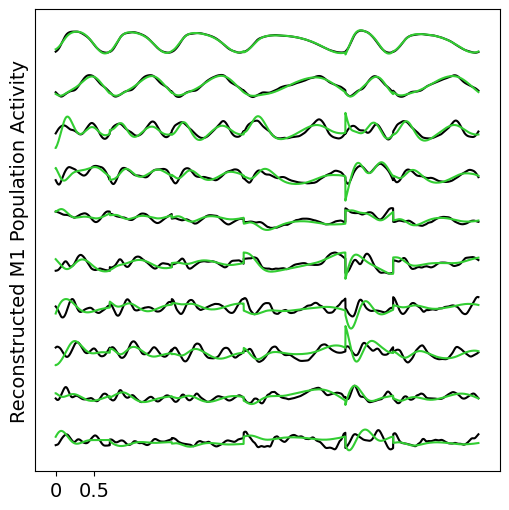

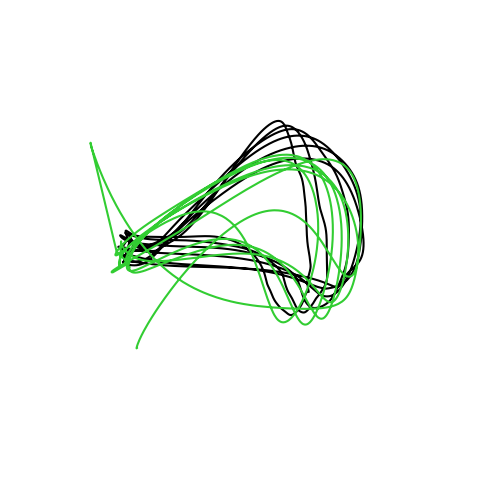

Now printing the correlations
CC1 R2 0.9942482501425972
CC2 R2 0.9717159215849547
CC3 R2 0.5673300170627738
CC4 R2 0.599311245783303
CC5 R2 0.6994454817801469
CC6 R2 0.5440635894160954
CC7 R2 -0.4018097953818902
CC8 R2 -0.06624239719614189
CC9 R2 0.39182721503963547
CC10 R2 -0.47502633278145723
Average R2 (Combined) [Agent Canonical Activity transformed in Exp PC Space] 0.3824863195450017


In [45]:
#Do the collective CCA for all the speeds

A_exp_cca = A_exp_cum
A_agent_cca = A_agent_cum

#Filter the agent's activity through 20ms gaussian filter as done with experimental data
# A_agent_cca = gaussian_filter1d(A_agent_cca.T, 20).T

#Select the number of components for PCA and CCA
n_comps = 10
PC_agent = PCA(n_components= n_comps)
PC_exp = PCA(n_components= n_comps)

A_exp_cca = PC_exp.fit_transform(A_exp_cca)
A_agent_cca = PC_agent.fit_transform(A_agent_cca)

cca = CCA(n_components =n_comps)
exp_c, agent_c = cca.fit_transform(A_exp_cca, A_agent_cca)

#Transform the canonical agent's activity back into the original experimental PC space
exp_prime = cca.inverse_transform(agent_c)

plt.figure(figsize= (6, 6))

for k in range(n_comps):
    if k==0:
        plt.plot(A_exp_cca[:,n_comps-1-k]/np.max(A_exp_cca[:,n_comps-1-k]) + k*4, linewidth=1.5, c = 'k')
        plt.plot(exp_prime[:,n_comps-1-k]/np.max(A_exp_cca[:,n_comps-1-k]) + k*4, linewidth= 1.5, c=(50/255, 205/255, 50/255), label= 'Network Reconstruction')
    else:
        plt.plot(A_exp_cca[:, n_comps -1 - k]/np.max(A_exp_cca[:,n_comps-1-k]) + k * 4, linewidth=1.5, c='k')
        plt.plot(exp_prime[:, n_comps -1 - k]/np.max(A_exp_cca[:,n_comps-1-k]) + k * 4, linewidth=1.5, c=(50 / 255, 205 / 255, 50 / 255))

plt.ylabel('Reconstructed M1 Population Activity', size=14)
plt.xticks([0, 500], ['0', '0.5'], size= 14)
plt.yticks([])
plt.show()

#Now plot the PCs on the same plot here
ax = plt.figure(figsize= (6,6), dpi=100).add_subplot(projection='3d')
ax.plot(A_exp_cca[:,0], A_exp_cca[:, 1], A_exp_cca[:, 2], c = 'k')
ax.plot(exp_prime[:,0], exp_prime[:, 1], exp_prime[:, 2], c=(50/255, 205/255, 50/255))

# Hide grid lines
ax.grid(False)
plt.grid(b=None)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')

plt.show()
# plt.savefig('C:/Users/malma/Dropbox/NatureFigs2/Fig2/PCA_619.svg', format='svg', dpi=300, transparent= True)


print('Now printing the correlations')

for comp in range(n_comps):
    print(f'CC{comp+1} R2', r2_score(A_exp_cca[:, comp], exp_prime[:, comp]))

sum = 0
for k in range(n_comps):
    sum = sum + r2_score(A_exp_cca[:, k], exp_prime[:, k])
average = sum / n_comps;

print('Average R2 (Combined) [Agent Canonical Activity transformed in Exp PC Space]', average)

In [47]:
#Transform the canonical experimental activity into the agent's population space

agent_prime = exp_c @ np.linalg.inv(cca.y_weights_)
agent_prime = agent_prime * np.std(A_agent_cca, axis= 0) + np.mean(A_agent_cca, axis= 0)

#Plot the R2 between the transform exp_canonical and agent population activity
sum = 0
for k in range(n_comps):
    print(f'CC{k+1} R2', r2_score(A_agent_cca[:, k], agent_prime[:, k]))
    
    sum = sum + r2_score(A_agent_cca[:, k], agent_prime[:, k])
average = sum / n_comps;

print('Average R2 (Combined) [Exp Canonical Activity transformed in Agent PC Space]', average)

CC1 R2 0.8421185966510031
CC2 R2 0.9668815486759929
CC3 R2 0.9771732159540966
CC4 R2 0.650270401548445
CC5 R2 0.27935159274261023
CC6 R2 0.11212105314265008
CC7 R2 -0.631171891316523
CC8 R2 -0.7000648412213246
CC9 R2 0.6534627743980339
CC10 R2 0.6752850223901805
Average R2 (Combined) [Exp Canonical Activity transformed in Agent PC Space] 0.3825427472965165


In [49]:
#Now find the explained variance ratio of the agent population/PC subspace for combined CCA Analysis

A_agent_z = (A_agent_cca - np.mean(A_agent_cca, axis= 0)) / np.std(A_agent_cca, axis= 0)
# A_agent_z = zscore(A_agent_cca, ddof= 1 )
A_agent_zm = A_agent_z - np.mean(A_agent_z, axis= 0)

#Find the covariance matrix of the agent population/pca activity
C_agent = (A_agent_zm.T@A_agent_zm)/(A_agent_zm.shape[0]-1)

variance_explained= 0
for comp in range(n_comps):
    explained_variance_ratio = (cca.y_weights_[:, comp]@C_agent@cca.y_weights_[:, comp].T)/np.sum(np.diag(C_agent))
    variance_explained += explained_variance_ratio
    print(f'Variance explained by CC{comp+1}', explained_variance_ratio)

print('Variance Explained', variance_explained)

Variance explained by CC1 0.10000010985021043
Variance explained by CC2 0.10000013549895356
Variance explained by CC3 0.09999987877443585
Variance explained by CC4 0.10000002040093958
Variance explained by CC5 0.09999993274751368
Variance explained by CC6 0.10000010812629914
Variance explained by CC7 0.10000010306148249
Variance explained by CC8 0.10000009061962879
Variance explained by CC9 0.10000030234209181
Variance explained by CC10 0.09999934241593843
Variance Explained 1.0000000238374935
